In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import re

## General data organization

In [20]:
df = pd.read_csv("student_responses.csv")

# rename column headers to be more succinct
df.columns = ["timestamp",
              "course",                             # Q1
              "how did you learn about comp bio?",  # Q2
              "courses w/ comp bio",                # Q3
              "time on comp bio",                   # Q4
              "instructor support",                 # Q5
              "course resource support",            # Q6
              "most helpful",                       # Q7
              "frustrations",                       # Q8
              "add. info",                          # Q9
              "graduating",                         # Q10
              "job app/acceptance impact",          # Q11
              "career plan impact",                 # Q12
              "demographics",                       # Q13
              "email"]                              # Q14

# insert column for respondent ID
df.insert(0, "ID", df.index, False)

Each respondent's unique identifier is the corresponding row's index.

## Individual questions
### Question 1
Standardize course codes:
1. Define a Levenshtein distance function, which will be used to resolve discrepancies between courses that took the survey and responses that indicate courses that are not included (i.e., likely typos).

In [21]:
# Calculates Levenshtein distance (i.e., the smallest number of alterations necessary to turn one word into another).
def levenshtein(a, b):
    len_a = len(a)
    len_b = len(b)
    
    # populate len_a x len_b matrix with 0s
    matrix = [[0 for _ in range(len_b + 1)] for _ in range(len_a + 1)]

    # populate first column of matrix with numbers starting from 0 in first row to len_a in last row...
    for i in range(len_a + 1):
        matrix[i][0] = i
    # ...and first row of matrix with numbers starting from 0 in first column to len_b in last column
    for j in range(len_b + 1):
        matrix[0][j] = j

    # populate matrix with computed edit distances
    for i in range(1, len_a + 1):
        for j in range(1, len_b + 1):
            if a[i - 1] == b[j - 1]:    # characters match
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                # minimum cost of insertion, deletion, or substitution
                matrix[i][j] = 1 + min(matrix[i][j - 1], matrix[i - 1][j], matrix[i - 1][j - 1])

    # return edit distance between a and b
    return matrix[len_a][len_b]

2. Enforce a course code standard and resolve discrepancies in responses using the previously-defined Levenshtein distance function. The course code standard is as follows:
   1. 4 uppercase letters denoting subject followed by
   2. 3 digits and (optionally) a single uppercase letter denoting course number.

In [22]:
# regexes to look for
subject_pattern = re.compile("[A-Za-z]{4}")         # e.g., "BSCI" or "BIOE"
number_pattern = re.compile("[0-9]{3}[A-Za-z]?")    # e.g., "171" or "330"

# dictionary of courses recorded in survey
course_list = {"BSCI330": "Cell Biology and Physiology",
               "BSCI171": "Principles of Molecular & Cellular Biology Laboratory",
               "BSCI161": "Principles of Ecology and Evolution Lab",
               "BSCI403": "Biology of Vision",
               "BSCI462": "Population Ecology",
               "BSCI410": "Molecular Genetics",
               "BSCI170": "Principles of Molecular & Cellular Biology",
               "BSCI401": "Animal Communication",
               "BIOL708W": "Animal Communication",
               "BIOE241": "Biocomputational Methods"}

In [23]:
# iterate through each response in "course" column and standardize course codes + resolve discrepancies
for i in range(len(df["course"])):
    subject = subject_pattern.search(df["course"][i]).group().upper() if subject_pattern.search(df["course"][i]) else ""
    number = number_pattern.search(df["course"][i]).group().upper() if number_pattern.search(df["course"][i]) else ""

    # standardize course code (e.g., biol708w -> BIOL708W) and resolve discrepancies
    if len(number) == 0:    # only "BSCI" -- i.e., ambiguous course code
        df.at[i, "course"] = subject + " (ambiguous)"
    else:
        df.at[i, "course"] = subject + number

        # needs to be modified based on Levenshtein distance
        if df["course"][i] not in course_list:
            minimum = len(df["course"][i])

            # find key with smallest Levenshtein distance from course code
            for key in course_list:
                dist = levenshtein(key, df["course"][i])
                
                if dist < minimum:  # first minimum (in case of tie) selected
                    minimum = dist
                    df.at[i, "course"] = key

### have to check whether Levenshtein distance is best way to resolve discrepancies. BSCI708W does not seem to
### turn into BIOL708W (as evidenced by the bar chart).
### perhaps instead of Levenshtein distance, compare strings lexicographically?

Generate bar chart of course data:

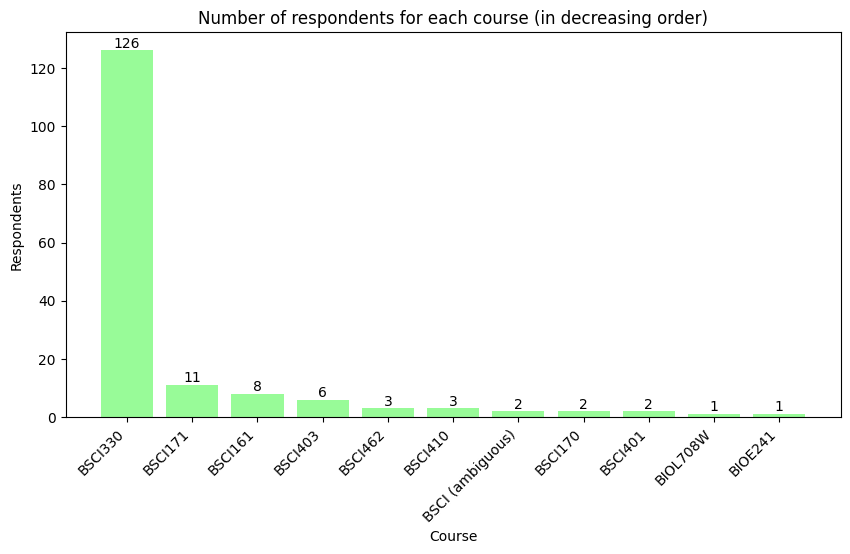

In [24]:
count = df["course"].value_counts() # y-values -- number of respondents
courses = count.index.tolist()      # x-values -- courses

# generate bar chart
plt.figure(figsize=(10, 5))
plt.bar(courses, count, color="palegreen")

# add labels
plt.title("Number of respondents for each course (in decreasing order)")
plt.xlabel("Course")
plt.ylabel("Respondents")
plt.xticks(rotation=45, ha="right")

# display values above each bar
for i in range(len(courses)):
    plt.text(i, count.iloc[i], count.iloc[i], ha="center", va="bottom")

plt.show()